In [1]:
import numpy as np
import scipy.io as sio
import pandas as pd

mat_data = sio.loadmat('mat_file_my.mat');X = mat_data['X_all'];Y = mat_data['Y_all']
PC = pd.DataFrame(X, columns=['B', 'H', 'Lam', 'frebar', 'fc', 'fy','d_steel', 'ro_rebar', 'tf_tw_2', 'cH', 'cB','e'])
PC['P_exp']=Y

B = PC['B']; H = PC['H']; lam = PC['Lam']; frebar = PC['frebar']; fc = PC['fc']; fy = PC['fy']
d_steel = PC['d_steel']; ro_rebar = PC['ro_rebar']; tf_tw_2 = PC['tf_tw_2']; cH = PC['cH']; cB = PC['cB']

A_rebar_4 = ro_rebar * B * H / 4.0; cover = 30; L = lam * B;hs2 = (H - 2.0 * cH) / 2.0;bf2 = (B - 2.0 * cB) / 2.0

A_steel_4 = (4.*A_rebar_4 * frebar + 0.85 * B * H * 0.97 * fc) * d_steel / fy / 4.0
tw2 = A_steel_4 / ((bf2 - 4.0) * tf_tw_2 + hs2)
tf = (A_steel_4 - hs2 * tw2) / (bf2 - tw2)


f_fc = 0.85;Es = 210000;Ec = 22000 * ((fc + 8.) / 10.)**0.3
Ar = ro_rebar * B * H
As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
Ac = H * B - Ar - As
I_S_X = ((hs2 * 2.)**3. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**3 * (bf2 * 2. - 2. * tw2)) / 12.0
I_REBAR_X = Ar * (H - 2.0 * cover)**2. / 4.0
EI1 = (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.6
I_S_Y = ((bf2 * 2.)**3. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**3) / 12.0
I_REBAR_Y = Ar * (B - 2.0 * cover)**2. / 4.0
EI2 = (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.6
EI = np.minimum(EI1, EI2)

pc = Ac * fc * f_fc
pa = pc + As * fy + Ar * frebar

Ncr = (np.pi**2. * EI) / (L * L)
slender = (pa / Ncr)**0.5
phi = 0.5 * (1 + 0.21 * (slender - 0.2) + slender**2)
chi = np.minimum(1, 1 / (phi + (phi**2 - slender**2)**0.5))
EC4 = chi * pa/1000.0/PC['P_exp']

PC['e_B']=np.exp(PC['e'])-0.9
PC['tw2']=tw2;PC['tf']=tf;PC['delta']=(As * fy)/pa;PC['bf2']=bf2;PC['hs2']=hs2;PC['A_rebar']=A_rebar_4*4.0
X=PC[['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','e_B']];y=PC['P_exp']/pa

In [2]:
from scipy.stats import skew, kurtosis
from tabulate import tabulate
# Create a list to store the statistical properties for each feature
PC['slender']=slender
PC['tw']=2.0*PC['tw2'];PC['hs']=2.0*PC['hs2'];PC['bf']=2.0*PC['bf2'];PC['rho_l']=PC['A_rebar']/PC['B']/PC['H'];PC['fy']=fy;PC['P_PcS']=y;PC['P_PcS1']=y*1000.0
features = ['B', 'H', 'Lam', 'frebar', 'fc','fy', 'delta','tw', 'tf', 'hs', 'bf','rho_l','slender','e_B','P_exp', 'P_PcS1']
X1=PC[['B', 'H', 'Lam', 'frebar', 'fc','fy', 'delta','tw', 'tf', 'hs', 'bf','rho_l','slender','e_B','P_exp', 'P_PcS1']]
correlation_matrix = X1.corr()
print(correlation_matrix)
data_stats = pd.DataFrame()

# Calculate statistical properties for each feature
data_stats['Min'] = PC[features].min()
data_stats['Max'] = PC[features].max()
data_stats['Mean'] = PC[features].mean()
data_stats['Std'] = PC[features].std()
data_stats['Skewness'] = PC[features].apply(skew)
data_stats['Kurtosis'] = PC[features].apply(kurtosis)

# Display the statistical properties
print(data_stats)

                B         H       Lam    frebar        fc        fy     delta  \
B        1.000000 -0.123266 -0.007554 -0.057413 -0.105664 -0.004889 -0.105019   
H       -0.123266  1.000000 -0.028393 -0.012341 -0.074451  0.043174  0.010449   
Lam     -0.007554 -0.028393  1.000000  0.046107  0.035288  0.072587  0.013880   
frebar  -0.057413 -0.012341  0.046107  1.000000  0.008429 -0.006819  0.031235   
fc      -0.105664 -0.074451  0.035288  0.008429  1.000000 -0.019867 -0.041067   
fy      -0.004889  0.043174  0.072587 -0.006819 -0.019867  1.000000 -0.001221   
delta   -0.105019  0.010449  0.013880  0.031235 -0.041067 -0.001221  1.000000   
tw      -0.191613  0.218138 -0.001443  0.098750  0.369547 -0.371194  0.650188   
tf      -0.215242  0.228064 -0.008641  0.110125  0.365231 -0.384562  0.668756   
hs      -0.104842  0.972367 -0.028776 -0.008000 -0.083449  0.047533 -0.002705   
bf       0.899241 -0.114011 -0.020893 -0.074484 -0.102527 -0.010634 -0.092888   
rho_l   -0.085372 -0.097647 

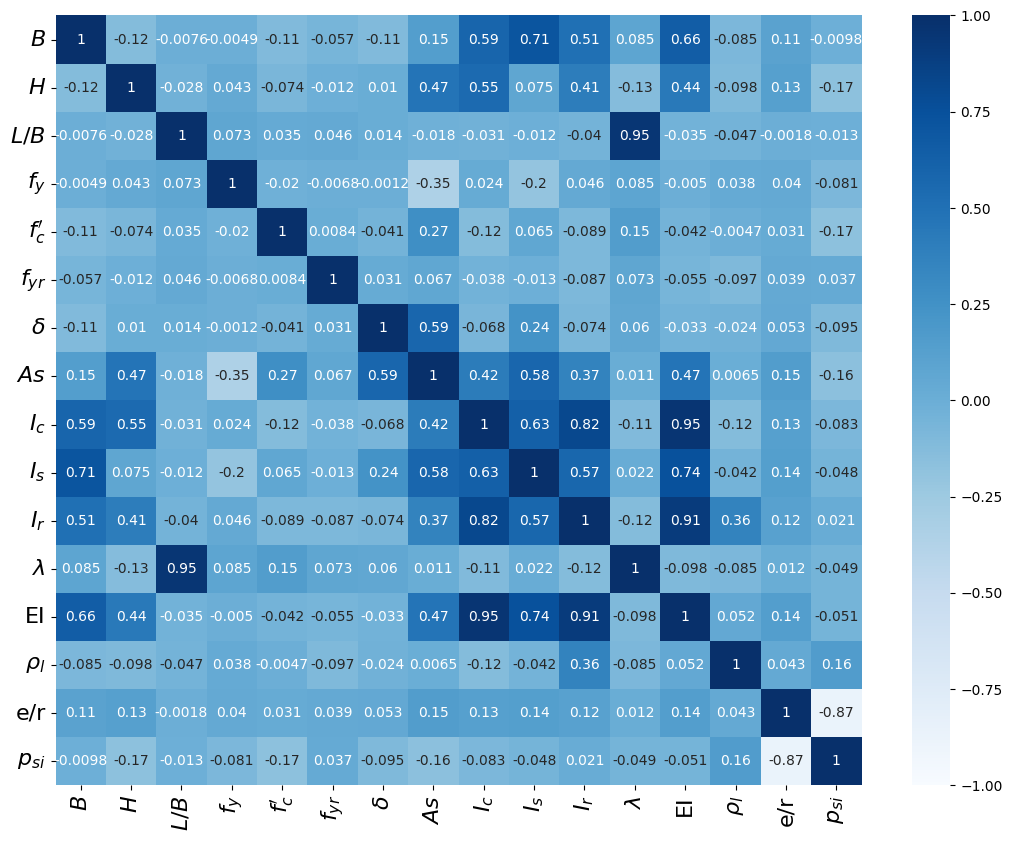

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PC['As']=As; PC['Ic']=np.minimum((H**3. * B/12.0 - I_S_X - I_REBAR_X),(H * B**3./12.0 - I_S_Y - I_REBAR_Y));PC['Is']=np.minimum(I_S_X,I_S_Y); PC['I_REBAR_X']=np.minimum(I_REBAR_X,I_REBAR_Y)
PC['EI']=EI;
X1=PC[['B', 'H', 'Lam', 'fy', 'fc','frebar', 'delta','As','Ic','Is','I_REBAR_X','slender','EI','rho_l','e_B', 'P_PcS']]
column_labels = ['$B$', '$H$', '$L/B$', '$f_y$', '$f^\\prime_c$','$f_{yr}$','$\\delta$','$As$','$I_c$', '$I_s$','$I_r$','$\\lambda$','EI','$\\rho_l$','e/r','$p_{si}$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(13, 10),)
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 11, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_CFS_y.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()


c:\Users\osama\anaconda3\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


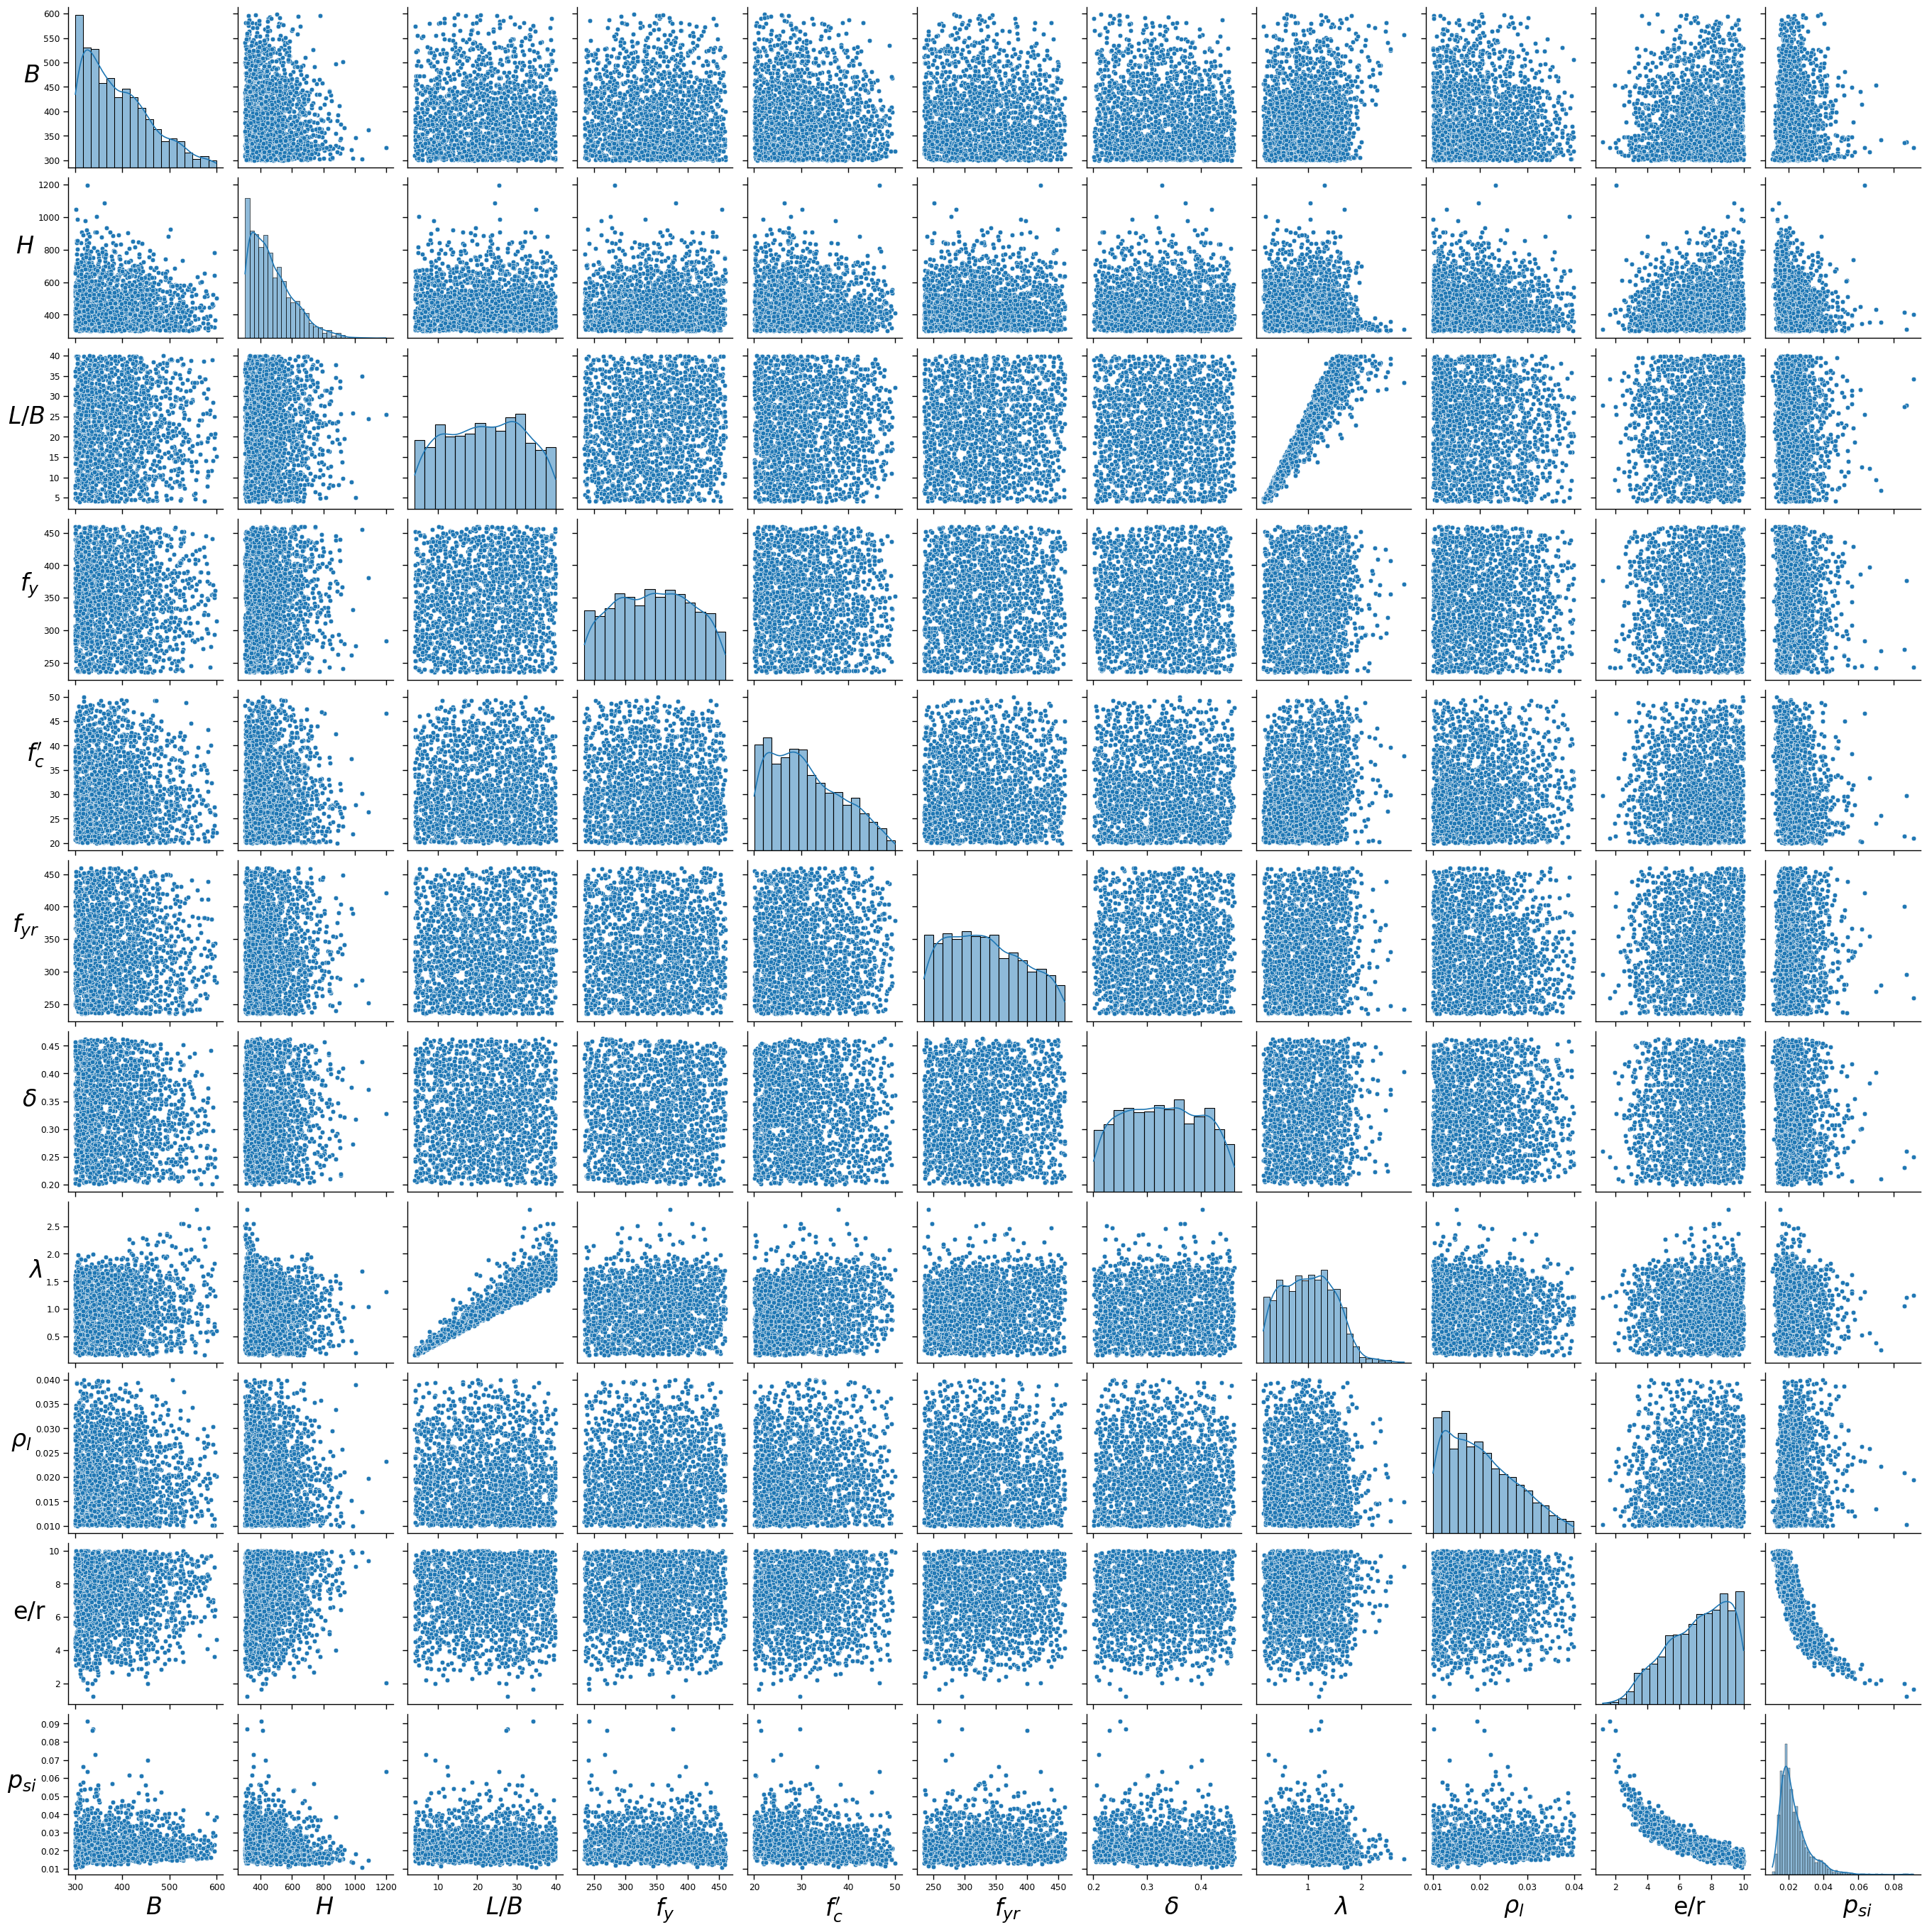

In [4]:
PC['XO']=1000.0*PC['P_PcS']
X1=PC[['B', 'H', 'Lam', 'fy', 'fc','frebar', 'delta','slender','rho_l','e_B', 'XO']]
x_vars = ['B', 'H', 'Lam', 'fy', 'fc','frebar', 'delta','slender','rho_l','e_B', 'XO']
aa=['$B$', '$H$', '$L/B$', '$f_y$', '$f^\\prime_c$','$f_{yr}$','$\\delta$','$\\lambda$','$\\rho_l$','e/r','$p_{si}$']
pairplot = sns.pairplot(X1, size=2.5, diag_kind='hist', diag_kws={'kde': True}, x_vars=x_vars)
i=0;j=0;font_size=24
for ax in pairplot.axes.flatten():
    ax.set_xlabel(aa[i],fontsize=font_size)
    ax.set_ylabel(aa[j],fontsize=font_size, rotation = 0)
    i=i+1
    if i==len(aa):
        i=0;j=j+1
    if j==len(aa):j=0
    ax.yaxis.get_label().set_horizontalalignment('right')
    ax.xaxis.get_label().set_horizontalalignment('left')
plt.savefig("correlation1_CFS_y.png")


In [6]:
from skopt import gp_minimize
from skopt import forest_minimize # Bayesian Optimization with RF as surrogate
from skopt import gbrt_minimize # Bayesian Optimization with GBM as surrogate
from skopt import Optimizer # for the optimization
from joblib import Parallel, delayed # for the parallelization
from skopt import dummy_minimize # for the randomized search
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
cv = KFold(n_splits=5, shuffle=True, random_state=1)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math
from math import pi

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel, WhiteKernel,RationalQuadratic,Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

PC  = pd.read_excel('AAA.xlsx',sheet_name='Sheet1')

X=PC[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12']];y=PC['Y']/PC['paa']*1000.0

X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=(0.5, 1))
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=13)

In [4]:
X_train, X_test, aa_train, aa_test = train_test_split(X_tot, np.array(PC['paa']).reshape(-1,1), test_size=0.2, random_state=13)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
import xgboost as xgb

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        #"num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("booster", ['gbtree', 'dart']),#, 'rf'
    }
    model = xgb.XGBRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-09-19 09:30:39,255] A new study created in memory with name: no-name-e75aa048-acda-4e24-815d-cafad6cac458
[I 2024-09-19 09:31:03,070] Trial 0 finished with value: 0.06327057933633515 and parameters: {'n_estimators': 65, 'learning_rate': 0.0633463914519445, 'gamma': 60.787542341488255, 'max_depth': 39, 'booster': 'dart'}. Best is trial 0 with value: 0.06327057933633515.
[I 2024-09-19 09:31:10,218] Trial 5 finished with value: 0.019679014305530464 and parameters: {'n_estimators': 1844, 'learning_rate': 0.0022985028645642765, 'gamma': 0.01672488388204073, 'max_depth': 46, 'booster': 'dart'}. Best is trial 5 with value: 0.019679014305530464.
[I 2024-09-19 09:31:10,568] Trial 11 finished with value: 0.06386429202709336 and parameters: {'n_estimators': 838, 'learning_rate': 0.14386890473364272, 'gamma': 46.43427875985251, 'max_depth': 6, 'booster': 'gbtree'}. Best is trial 5 with value: 0.019679014305530464.
[I 2024-09-19 09:31:13,963] Trial 2 finished with value: 0.06386416177592474

Best hyperparameters: {'n_estimators': 1899, 'learning_rate': 0.0022392654623402245, 'gamma': 0.010316024988483745, 'max_depth': 50, 'booster': 'dart'}
Best RMSE: 0.01738320546989671


In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
aa=xgb.XGBRegressor(random_state=1000,n_estimators=1899, max_depth=50, learning_rate=0.0022392654623402245, booster='dart', gamma=0.010316024988483745)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data2=np.concatenate((data,data1),axis=1)


df = pd.DataFrame(data2)
#df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','e_B','P_exp','P_pred'];PC=df
df.columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','P_exp','P_pred'];PC=df
filename = 'XGB_CFS_y.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0.01588974908709352
Data exported to XGB_CFS_y.xlsx


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from lightgbm.sklearn import LGBMRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        #"gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 16, 50),
        "num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt', 'dart']),#, 'rf'
    }
    model = LGBMRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

c:\Users\osama\anaconda3\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
[I 2024-09-19 09:35:13,955] A new study created in memory with name: no-name-06c4b575-0594-46b4-a303-56684082ae03
[I 2024-09-19 09:35:34,553] Trial 1 finished with value: 0.008551686008688523 and parameters: {'n_estimators': 1701, 'learning_rate': 0.10367932233213763, 'max_depth': 27, 'num_leaves': 16, 'boosting_type': 'dart'}. Best is trial 1 with value: 0.008551686008688523.
[I 2024-09-19 09:35:43,587] Trial 2 finished with value: 0.04286251593314672 and parameters: {'n_estimators': 767, 'learning_rate': 0.03720037964639108, 'max_depth': 20, 'num_leaves': 13, 'boosting_type': 'dart'}. Best is trial 1 with value: 0.008551686008688523.
[I 2024-09-19 09:35:43,991] Trial 11 finished with value: 0.009534736665849647 and parameters: {'n_estimators': 1201, 'learning_rate'

Best hyperparameters: {'n_estimators': 1697, 'learning_rate': 0.1972088568720645, 'max_depth': 25, 'num_leaves': 19, 'boosting_type': 'dart'}
Best RMSE: 0.007904129350299539


In [11]:
from lightgbm.sklearn import LGBMRegressor
aa=LGBMRegressor(n_estimators=1697,learning_rate=0.1972088568720645, max_depth=25, num_leaves=19, boosting_type='dart')
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data2=np.concatenate((data,data1),axis=1)

df = pd.DataFrame(data2)
#df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','e_B','P_exp','P_pred'];PC=df
df.columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','P_exp','P_pred'];PC=df

filename = 'LGBM_CFS_y.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

c:\Users\osama\anaconda3\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 1494, number of used features: 12
[LightGBM] [Info] Start training from score 0.577541
0.006639609988715643
Data exported to LGBM_CFS_y.xlsx


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        #"learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 50),
        "max_features": trial.suggest_categorical("max_features", ['sqrt','log2']),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),        
    }
    model = RandomForestRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50,n_jobs=-1)#os.cpu_count()-1
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-09-19 09:40:16,458] A new study created in memory with name: no-name-5eb0ace9-8228-4c35-81b0-77b43dd6429f
[I 2024-09-19 09:40:31,189] Trial 5 finished with value: 0.030338163569330456 and parameters: {'n_estimators': 127, 'max_depth': 37, 'min_samples_leaf': 50, 'max_features': 'log2', 'bootstrap': False}. Best is trial 5 with value: 0.030338163569330456.
[I 2024-09-19 09:40:32,402] Trial 0 finished with value: 0.022548239263748056 and parameters: {'n_estimators': 1552, 'max_depth': 20, 'min_samples_leaf': 13, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.022548239263748056.
[I 2024-09-19 09:40:36,035] Trial 1 finished with value: 0.030299203779055938 and parameters: {'n_estimators': 1140, 'max_depth': 43, 'min_samples_leaf': 50, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.022548239263748056.
[I 2024-09-19 09:40:38,645] Trial 10 finished with value: 0.029050157477245375 and parameters: {'n_estimators': 1145, 'max_depth

Best hyperparameters: {'n_estimators': 1738, 'max_depth': 25, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
Best RMSE: 0.01755355566546428


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
aa=RandomForestRegressor(random_state=1000,n_estimators=1738, max_depth=25, min_samples_leaf=2, max_features='sqrt', bootstrap=False)
print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data2=np.concatenate((data,data1),axis=1)
#df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','e_B','P_exp','P_pred'];PC=df
df = pd.DataFrame(data2)
df.columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','P_exp','P_pred'];PC=df

filename = 'RF_CFS_y.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0.017590436471183198


c:\Users\osama\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.01648359658091657
Data exported to RF_CFS_y.xlsx


In [11]:
import catboost as cb
import optuna
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-09-19 09:44:19,270] A new study created in memory with name: no-name-e7c3ca13-1e41-464d-b9e0-5ad8073d6b4c
[I 2024-09-19 09:44:22,046] Trial 1 finished with value: 0.02796207810155349 and parameters: {'iterations': 205, 'learning_rate': 0.014556332730493518, 'depth': 1, 'subsample': 0.5621763613830864, 'colsample_bylevel': 0.8832575378183926, 'min_data_in_leaf': 60}. Best is trial 1 with value: 0.02796207810155349.
[I 2024-09-19 09:45:20,901] Trial 2 finished with value: 0.03738016475561613 and parameters: {'iterations': 245, 'learning_rate': 0.005897316977007816, 'depth': 11, 'subsample': 0.7413526126810903, 'colsample_bylevel': 0.29553187583066015, 'min_data_in_leaf': 81}. Best is trial 1 with value: 0.02796207810155349.
[I 2024-09-19 09:45:34,913] Trial 5 finished with value: 0.019545440099658938 and parameters: {'iterations': 1143, 'learning_rate': 0.0076497377416504, 'depth': 10, 'subsample': 0.3372922498923779, 'colsample_bylevel': 0.11895252478430386, 'min_data_in_leaf': 

In [13]:
import catboost as cb
import optuna
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-09-19 11:10:18,441] A new study created in memory with name: no-name-dc72d833-0489-45cd-a3dc-ee0d70227ca2
[I 2024-09-19 11:10:21,111] Trial 10 finished with value: 0.05886253727789713 and parameters: {'iterations': 132, 'learning_rate': 0.003309610249376803, 'depth': 2, 'subsample': 0.31124979624816296, 'colsample_bylevel': 0.1630823129880612, 'min_data_in_leaf': 50}. Best is trial 10 with value: 0.05886253727789713.
[I 2024-09-19 11:10:23,963] Trial 1 finished with value: 0.05464733072564879 and parameters: {'iterations': 400, 'learning_rate': 0.0058181711012876966, 'depth': 8, 'subsample': 0.5256388225131453, 'colsample_bylevel': 0.052147190306742426, 'min_data_in_leaf': 85}. Best is trial 1 with value: 0.05464733072564879.
[I 2024-09-19 11:10:25,238] Trial 2 finished with value: 0.021107916047323625 and parameters: {'iterations': 475, 'learning_rate': 0.012884660398399023, 'depth': 1, 'subsample': 0.6742602385311338, 'colsample_bylevel': 0.981327952491245, 'min_data_in_leaf'

In [15]:
import catboost as cb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
aa=cb.CatBoostRegressor(iterations=1606,learning_rate=0.08951085394835617,depth=4,subsample=0.8389986748614825,colsample_bylevel=0.6620659826477936,min_data_in_leaf= 25)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data2=np.concatenate((data,data1),axis=1)


df = pd.DataFrame(data2)
#df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','e_B','P_exp','P_pred'];PC=df
df.columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','P_exp','P_pred'];PC=df
filename = 'CB_CFS_y.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0:	learn: 0.0493599	total: 142ms	remaining: 3m 47s
1:	learn: 0.0464054	total: 143ms	remaining: 1m 54s
2:	learn: 0.0438894	total: 144ms	remaining: 1m 16s
3:	learn: 0.0416978	total: 145ms	remaining: 57.9s
4:	learn: 0.0394793	total: 146ms	remaining: 46.6s
5:	learn: 0.0374803	total: 146ms	remaining: 39s
6:	learn: 0.0355754	total: 147ms	remaining: 33.6s
7:	learn: 0.0340493	total: 148ms	remaining: 29.6s
8:	learn: 0.0323240	total: 149ms	remaining: 26.4s
9:	learn: 0.0307267	total: 150ms	remaining: 23.9s
10:	learn: 0.0295712	total: 151ms	remaining: 21.9s
11:	learn: 0.0283526	total: 151ms	remaining: 20.1s
12:	learn: 0.0268929	total: 152ms	remaining: 18.7s
13:	learn: 0.0257329	total: 153ms	remaining: 17.4s
14:	learn: 0.0247567	total: 154ms	remaining: 16.3s
15:	learn: 0.0238000	total: 154ms	remaining: 15.3s
16:	learn: 0.0229072	total: 155ms	remaining: 14.5s
17:	learn: 0.0221784	total: 156ms	remaining: 13.8s
18:	learn: 0.0214034	total: 157ms	remaining: 13.1s
19:	learn: 0.0206397	total: 157ms	remain

# SVR

In [9]:
import pso
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math

num_folds=5
def objective_function(params):
    C, epsilon, gamma = params
    mse_scores = []
    
    # Split the data into folds
    fold_size = len(X_train) // num_folds
    folds_X = np.array_split(X_train, num_folds)
    folds_y = np.array_split(y_train, num_folds)
    
    # Perform cross-validation
    for i in range(num_folds):
        # Create the SVR model
        model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
        
        # Merge the data for training and testing
        X_test_fold,X_train_fold = folds_X[i], np.concatenate(folds_X[:i] + folds_X[i+1:])
        y_test_fold,y_train_fold = folds_y[i], np.concatenate(folds_y[:i] + folds_y[i+1:])

        # Train the model and predict
        model.fit(X_train_fold, y_train_fold.reshape(-1))
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculate the mean squared error
        divide = scaler_out.inverse_transform(y_pred_fold.reshape(-1, 1))/scaler_out.inverse_transform(y_test_fold.reshape(-1, 1))
        mse_fold = np.std(divide)
        
        mse_scores.append(mse_fold)
    
    # Calculate the mean of the mse scores
    mse = np.mean(mse_scores)
    return mse
lower_bound = [-3., -100.,-10.]
upper_bound = [5., -10., 20.]


# Define Optimization Problem
problem = {'CostFunction': objective_function, 'nVar': 3, 'VarMin': lower_bound, 'VarMax': upper_bound}

# Running PSO
gbest, pop = pso.PSO(problem, MaxIter = 10, PopSize = 100, c1 = 1.0, c2 = 1.0, w = 0.1, wdamp = 0.1)
# Final Result
print('Global Best:')
print(gbest)


Iteration 0: Best Cost = 0.01722960446973539
Global Best:
{'position': array([  4.65388317, -11.54475146,  -3.79118683]), 'cost': 0.01722960446973539}


In [23]:
score = objective_function(gbest['position'])
print(gbest['cost'])
C, epsilon, gamma = gbest['position']#4.65388317, -11.54475146,  -3.79118683


model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
model.fit(X_train, y_train.reshape(-1))
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = model.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data2=np.concatenate((data,data1),axis=1)

df = pd.DataFrame(data2)
#df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','e_B','P_exp','P_pred'];PC=df
df.columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','P_exp','P_pred'];PC=df
filename = 'SVR_CFS_y.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

Data exported to SVR_CFS_y.xlsx


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel, WhiteKernel,RationalQuadratic,Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
pi = math.pi
from sklearn.model_selection import cross_val_score

# Define the GPR model
gpr = GaussianProcessRegressor()
gpr.kernel = (
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=1.0) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    WhiteKernel(noise_level=0.1) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RationalQuadratic(length_scale=1, alpha=1)
)

# Set up the parameter grid for alpha
alpha_values = [0.0001,0.0005,0.001,0.0013]  # Add more values if needed

# Perform cross-validation to find the best alpha
best_alpha = None
best_score = -np.inf
for alpha in alpha_values:
    gpr.alpha = alpha
    scores = cross_val_score(gpr, X_train, y_train.reshape(-1, 1), cv=5)  # Use your desired number of folds
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha


c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process

In [12]:
print(best_alpha)

0.0001


In [13]:
# Fit the GPR model with the best alpha
gpr.alpha = best_alpha
gpr.fit(X_train, y_train.reshape(-1, 1))

# Make predictions using the trained model
y_pred, y_std = gpr.predict(X_normalized, return_std=True)
if y_tot.ndim>1 and y_tot.shape[1]==1:y_tot=np.squeeze(y_tot,axis=1)
y_tot11=y_tot;y_std11=y_std;y_pred11=y_pred


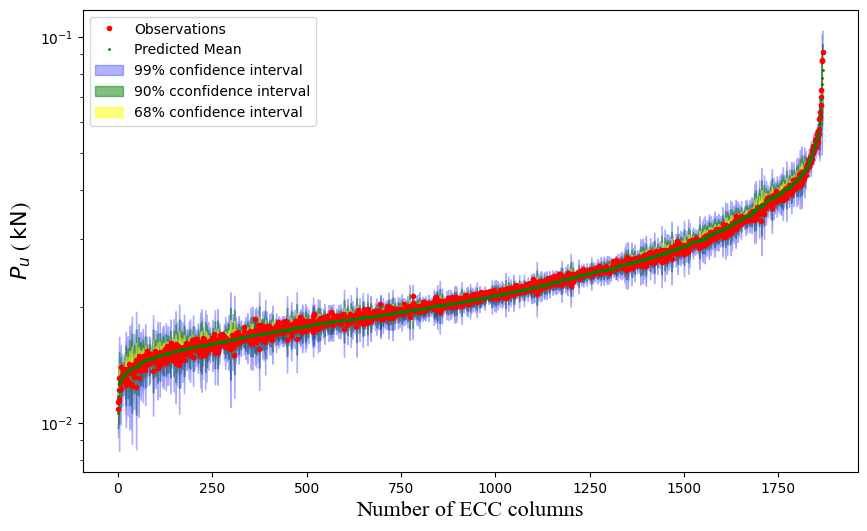

In [14]:
y_tot11=y_tot;X_tot11=X_tot;y_pred11=y_pred;y_std2=y_std
yr=y_std2.reshape(-1, 1)+y_pred.reshape(-1, 1)
data = scaler_out.inverse_transform( y_tot11.reshape(-1, 1))
data1= scaler_out.inverse_transform(y_pred11.reshape(-1, 1))
yr   = scaler_out.inverse_transform(yr.reshape(-1, 1))
y_std2=yr.reshape(-1, 1)-data.reshape(-1, 1)
X     =     scaler.inverse_transform(X_tot)



data2=np.concatenate((X,data.reshape(-1, 1),data1.reshape(-1, 1)),axis=1)
df = pd.DataFrame(data2)
df.columns = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','P_exp','P_pred'];PC_ecc=df;PC_ecc['sd']=y_std2
y_tot11=np.array(PC_ecc['P_exp'].values);y_pred11=np.array(PC_ecc['P_pred'].values);y_std2=np.array(PC_ecc['sd'].values)

filename ='Gpr_Rect_ecc1_m12342y.xlsx'
PC_ecc.to_excel(filename, index=False)


#arrange
vv = np.vstack((X_tot11.transpose(),y_std2,y_tot11,y_pred11)).transpose()
v1 = vv[np.argsort(vv[:, -1])]
#previous sheet excel is wrong as you didnot sort x_tot
X_tot11,y_std2,y_tot11,y_pred11=v1[:,:-3],v1[:,-3],v1[:,-2],v1[:,-1]
# Calculate the upper and lower confidence bounds
#0.674
#2.576 is 99% confidence 1.96 is 95%confidence interval #1.645 is 90% #2.576 for 99% #1.0 for 68%
lower_bound99 = y_pred11.flatten() - 2.576* y_std2.flatten();upper_bound99 = y_pred11.flatten() + 2.576* y_std2.flatten()#99% confidence
lower_bound90 = y_pred11.flatten() - 1.645* y_std2.flatten();upper_bound90 = y_pred11.flatten() + 1.645* y_std2.flatten()#1.645 is 90%
lower_bound68 = y_pred11.flatten() - 1.0  * y_std2.flatten();upper_bound68 = y_pred11.flatten() + 1.0  * y_std2.flatten()#1.0 for 68%
# Plot the data, true function, and confidence intervals
plt.figure(figsize=(10, 6))
sizy=np.arange(lower_bound68.shape[0])
plt.semilogy(sizy, y_tot11, 'ro', label='Observations', markersize=3);plt.semilogy(sizy, y_pred11, 'go', label='Predicted Mean', markersize=1)
# Fill between the confidence bounds
plt.fill_between(sizy, upper_bound90.flatten(), upper_bound99.flatten(), color='blue', alpha=0.3,label='99% confidence interval')
plt.fill_between(sizy, upper_bound68.flatten(), upper_bound90.flatten(), color='green', alpha=0.5,label='90% cconfidence interval')
plt.fill_between(sizy, lower_bound68.flatten(), upper_bound68.flatten(), color='yellow', alpha=0.5,label='68% confidence interval')
plt.fill_between(sizy, lower_bound90.flatten(), lower_bound68.flatten(), color='green', alpha=0.5)
plt.fill_between(sizy, lower_bound99.flatten(), lower_bound90.flatten(), color='blue', alpha=0.3)

plt.xlabel('Number of ECC columns',fontdict={'fontname': 'Times New Roman', 'fontsize': 16});plt.ylabel(r'$P_{u}$ ($ \, \mathrm{kN}$)',fontdict={'fontname': 'Times New Roman', 'fontsize': 16});
plt.legend()
plt.savefig("GPR_Predicted_Mean_Confidence_Intervals1.png", dpi=500)
plt.show()
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = gpr.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data2=np.concatenate((data,data1),axis=1)


df = pd.DataFrame(data2)
df.columns = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','P_exp','P_pred'];PC_ecc=df;PC_ecc['sd']=y_std2
y_tot11=np.array(PC_ecc['P_exp'].values);y_pred11=np.array(PC_ecc['P_pred'].values);y_std2=np.array(PC_ecc['sd'].values)

filename ='GPR_CFS_y.xlsx'
PC_ecc.to_excel(filename, index=False)


# Proposed Design

In [15]:
import numpy as np
from scipy.optimize import fsolve
import scipy.io as sio
import pandas as pd

from math import pi
def get_m_from_n(axis, nn, pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi):
    if axis ==1:
        n = nn;sign=1.0
        if nn>pc/2.0: n = pc/2.0-(nn-pc/2.0);sign=-1.0
        min_zr = 0.0
        hn = (-n*2.0 + 0.85*fc*Ac)/2.0/(0.85*fc*(B-tw) + 2*fy*tw )
        if abs(hn)<hs/2.0-tf:
            zsn = tw*hn**2.0
            a=0.0
        else:
            hn = (-n*2.0 + 0.85*fc*(H*B-hs*bf) - 2*fy*(As-hs*bf))/2.0/(0.85*fc*(B-tw) + 2*fy*tw )
            hn = (-n*2   + pc- 2.0*(As-hs*bf)*(fy-fc*0.85/2.0))/2.0/(0.85*fc*B + 2*bf*(fy-0.85*fc/2.0))
            if hn<hs/2:
                zsn=zs -bf*(hs/2-hn)*(hs/2+hn)
                a=1.0
            else:
                hn = (-n*2.0 + 0.85*fc*(H*B)-2.*fy*As - 2*fr*Ar)/2.0/(0.85*fc*B)
                hn1=hn
                t=0
                if hn>H/2.0-cover:
                    zsn =zs
                    min_zr=Ar*(H/2.0-cover)
                    a=2.0
                    t=1
                if t==0: hn = (-n*2.0 + 0.85*fc*(Ac+As)-2*fy*As)/2.0/(0.85*fc*B)
                hn2=hn
                if hn<H/2.0-cover and t ==0:
                    zsn =zs
                    t=1
                    a=3.0
                if t==0:
                    hn=H/2.0-cover
                    #print('f   ',hn2,hn,hn1)
                    zsn = zs
                    min_zr = Ar*(H/2.0-cover)*(hn2-hn)/(hn2-hn1)
                    a=4.0
                
        zcn = B*hn**2.0-zsn -min_zr
    else:
        #minor
        n = nn;sign=+1.0
        if nn>pc/2.0: n = pc/2.0-(nn-pc/2.0);sign=-1.0

        min_zr = 0.0
        hn = (-n*2.0 +0.85*fc*(Ac+As-2.*tf*bf)-2.*fy*(As-2.*tf*bf))/2.0/(4.*tf*fy+(H-2.*tf)*0.85*fc)
        hn=(-n+0.5*0.85*fc*Ac)/((H-hs)*0.85*fc+2.0*hs*fy)
        if abs(hn)<tw/2.0: 
            zsn = (2.*hn)**2.0*hs/4.0
            a=0.0
        else:
            hn = (-n*2.0 +0.85*fc*(Ac+As-2.*tf*bf)-2.*fy*(As-2.*tf*bf))/2.0/(4.*tf*fy+(H-2.*tf)*0.85*fc)
            if hn<bf/2.0:
                zsn = zs -2*tf*(bf/2+hn)*(bf/2-hn)
                a=1.0
                #print(1,'   ',hn)
            else:
                pa=pc+As*fy+Ar*fr
                hn = (-n*2.0 +0.85*fc*(H*B)-2.0*fy*As-2.0*fr*Ar)/2.0/(0.85*fc*H)
                hn1=hn
                t=0
                if hn>B/2.0-cover:
                    #hn = (-n - pa +0.85*fc*(H*B))/(2.0*0.85*fc*H)
                    min_zr = Ar*(B/2.0-cover)
                    a=2.0
                    zsn = zs
                    t=1
                    #print(2,'   ',hn)
                if t==0: hn = (-n*2.0 +0.85*fc*(Ac+As)-2*fy*As)/2.0/(0.85*fc*H)
                hn2=hn
                if hn<B/2.0-cover and t ==0:
                    #hn = (-n - pa +2.0*Ar*fr + 0.85*fc*(H*B))/(2.0*0.85*fc*H)
                    zsn = zs; a=3.0;t=1
                    #print(3,'   ',hn)
                if t==0:
                    hn=B/2.0-cover
                    #print('f   ',hn2,hn,hn1)
                    zsn = zs;   a=4.0
                    min_zr = Ar*(B/2.0-cover)*(hn2-hn)/(hn2-hn1)
        zcn = H*hn**2.0-zsn- min_zr;   
                
          
    MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr)#0.3567238630812056
    #print(nn,n/1000.0,hn,MMM/1000.0/1000.0)
    MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr)+(B/2.0+sign*hn)**2.0*H/2.0*0.2*fc**0.75  #0.15134395352083815
    return MMM 
def get_m_for_ecc_And_2ndorder_MN_diagramR(axis,m, method, ec, ee, Ncr, pc, pa,MD, Ar, fr,cover, H,B, fc, Ac, As, fy, bf,tw,hs,tf,zs, f_fc, xi):
    i = 0
    eess=0
    while i < 50:
        #print('Ncr', Ncr)
        if method == 'DSM':
            n = 1 / (ec / m + 1 / Ncr)
        else:
            n = m / ee
        if n<0.0:
            n=0.
        if n > pa:
            n = pa * 0.99
        mm = get_m_from_n(axis, n,pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi)
        r = m - mm
        #print('r',r)
        #print('m',m)
        #print('mm',mm)
        if abs(r) / max(abs(mm),10.0) < 0.001:
            #print('break');
            break
        m = mm
        i=i+1
        if i == 49:    eess = 1
    #print('true ecc', mm/n)
    if eess == 1:
        eess = 0
        i=0
        while i < 1000:
            i=i+1 
            n = i / 1000 * pa
            if method == 'DSM':
                m = n * ec / (1 - n / Ncr)
            else:
                m = n * ee
            
            mm = get_m_from_n(axis, n, pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi)
            if m > mm:
                break
        if i == 1000:  eess = 1
    #print(m/n)        
    return m, n, eess

def EC4RA(X, ntest):
    B = X[0]; H = X[1]; lam = X[2]; frebar = X[3]; fc = X[4]; fy = X[5]
    d_steel = X[6]; ro_rebar = X[7]; tf_tw_2 = X[8]; cH = X[9]; cB = X[10]
    axis = 2; 
    if axis ==1: et = (np.exp(X[11])-0.9)*H;    eb = et
    if axis ==2: et = (np.exp(X[11])-0.9)*B;    eb = et
    #axis =  X[11]; et =  X[12]; eb =  X[12]
    
    Astr = 50; S_space = 1000 * 50 * 2 / min(B, H); fstr = 250.0;  A_rebar_4 = ro_rebar * B * H / 4.0; cover = 30
    L = lam * B;    hs2 = (H - 2.0 * cH) / 2.0;     bf2 = (B - 2.0 * cB) / 2.0
    
    A_steel_4 = (4.*A_rebar_4 * frebar + 0.85 * B * H * 0.97 * fc) * d_steel / fy / 4.0; tw2 = A_steel_4 / ((bf2 - 4.0) * tf_tw_2 + hs2); tf = (A_steel_4 - hs2 * tw2) / (bf2 - tw2)
    
    #frebar1=fy;fy=frebar;frebar=frebar1
    f_fc = 0.85;  Es = 210000;  Ec = 22000 * ((fc + 8.) / 10.)**0.3
    Ar = ro_rebar * B * H;  As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2));  Ac = H * B - Ar - As
    
    I_S_X = ((hs2 * 2.)**3. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**3 * (bf2 * 2. - 2. * tw2)) / 12.0
    I_REBAR_X = Ar * (H - 2.0 * cover)**2. / 4.0
    EI1 = (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.6
    
    I_S_Y = ((bf2 * 2.)**3. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**3) / 12.0
    I_REBAR_Y = Ar * (B - 2.0 * cover)**2. / 4.0
    EI2 = (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.6
    EI = min(EI1, EI2)
    #print(EI1/EI2)
    pc = Ac * fc * f_fc
    pa = pc + As * fy + Ar * frebar
    
    Ncr = (np.pi**2. * EI) / (L * L)
    slender = (pa / Ncr)**0.5
    #print(slender)
    #phi = 0.5 * (1 + 0.21 * (slender - 0.2) + slender**2);chi = min(1, 1 / (phi + (phi**2 - slender**2)**0.5));EC4 = chi * pa ;print(chi);ratioECP1 = ntest[0] / EC4*1000

    ##########################################if axis == 1:
    ok_EC4 = 1;ok_AISC = 1;ok_ECP = 1;compact = 1;short = 1; MN = 0; inrange = 0#   if range[0] < ratioEC4 < range[1]:   inrange = 1
    ee = max(abs(et), abs(eb))
    # EC4
    xi = 1.0
    if axis == 1:
        beta = max(0.44, 0.66 + 0.44 * np.sign(et * eb) * min(abs(et), abs(eb)) / ee)
        EI1 = 0.9*( (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.5 )
        Ncr = (np.pi**2 * EI1) / (L * L)
        ec = max(L / 2000., ee * beta)
        
        zs = ((hs2 * 2.)**2. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**2 * (bf2 * 2. - 2. * tw2)) / 4.0
        zr = Ar * (H - 2.0 * cover) / 2.0
        zc = H**2. * B/4.0 - zs-zr;     MD = (zs * fy + zr * frebar + 0.5 * f_fc * zc * fc)

        m,n,conver = get_m_for_ecc_And_2ndorder_MN_diagramR(axis,10, 'DSM', ec, ee, Ncr, pc, pa,MD, Ar, frebar,cover, H,B, fc, Ac, As, fy, 2.0*bf2,2.0*tw2,2.0*hs2,tf,zs, f_fc, xi)
        #EC4 = min(EC4, n / 1000)
        EC4 = n/1000
    else:
        beta = max(0.44, 0.66 + 0.44 * np.sign(et * eb) * min(abs(et), abs(eb)) / ee)
        EI2 = ( (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.9)
        Ncr = (np.pi**2 * EI2) / (L * L)
        ec = max(L / 3000., ee * beta)
        #print(ec)
        zs = ((bf2 * 2.)**2. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**2.) / 4.0
        zr = Ar * (B - 2.0 * cover) / 2.0
        zc = H * B**2./4.0 - zs-zr;     MD = (zs * fy + zr * frebar + 0.5 * f_fc * zc * fc)
        m,n,conver = get_m_for_ecc_And_2ndorder_MN_diagramR(axis,10, 'DSM', ec, ee, Ncr, pc, pa,MD, Ar, frebar,cover, H,B, fc, Ac, As, fy, 2.0*bf2,2.0*tw2,2.0*hs2,tf,zs, f_fc, xi)
        #EC4 = min(EC4, n / 1000)
        EC4 = n/1000
        #print(m/n)

    ratioEC4 = ntest / EC4
    #print(et/H, slender,ratioEC4[0])
    #if range[0] < ratioEC4 < range[1]:    inrange = 1
    return ratioEC4[0], conver, m/n, pa,EC4

mat_data = sio.loadmat('mat_file_my.mat');X = mat_data['X_all'];Y = mat_data['Y_all']

# Calculate the ratio for each specimen
results = np.array([EC4RA(X[i, :], Y[i]) for i in range(X.shape[0])])

ratios = results[:, 0]; paa=results[:,3];EC4=results[:,4]
df = pd.DataFrame(np.hstack([X, Y.reshape(-1, 1), Y.reshape(-1, 1),  ratios.reshape(-1, 1),  paa.reshape(-1, 1),  EC4.reshape(-1, 1)]), 
                  columns=[f'X{i+1}' for i in range(X.shape[1])] + ['P_exp','Y', 'Ratio Ntest/NEC4', 'paa','P_pred'])

# Export the DataFrame to an Excel sheet
output_file = 'prop_CFS_y1.xlsx'
df.to_excel(output_file, index=False)
print("prop_CFS: mean and CoV", np.mean(ratios),np.std(ratios)/np.mean(ratios))

prop_CFS: mean and CoV 1.0452279572493726 0.02786882197229003


# EC4

In [277]:
import numpy as np
from scipy.optimize import fsolve
import scipy.io as sio
import pandas as pd

from math import pi
def get_m_from_n(axis, nn, pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi):
    if axis ==1:
        n = nn;sign=1.0
        if nn>pc/2.0: n = pc/2.0-(nn-pc/2.0);sign=-1.0
        min_zr = 0.0
        hn = (-n*2.0 + 0.85*fc*Ac)/2.0/(0.85*fc*(B-tw) + 2*fy*tw )
        if abs(hn)<hs/2.0-tf:
            zsn = tw*hn**2.0
            a=0.0
        else:
            hn = (-n*2.0 + 0.85*fc*(H*B-hs*bf) - 2*fy*(As-hs*bf))/2.0/(0.85*fc*(B-tw) + 2*fy*tw )
            hn = (-n*2   + pc- 2.0*(As-hs*bf)*(fy-fc*0.85/2.0))/2.0/(0.85*fc*B + 2*bf*(fy-0.85*fc/2.0))
            if hn<hs/2:
                zsn=zs -bf*(hs/2-hn)*(hs/2+hn)
                a=1.0
            else:
                hn = (-n*2.0 + 0.85*fc*(H*B)-2.*fy*As - 2*fr*Ar)/2.0/(0.85*fc*B)
                hn1=hn
                t=0
                if hn>H/2.0-cover:
                    zsn =zs
                    min_zr=Ar*(H/2.0-cover)
                    a=2.0
                    t=1
                if t==0: hn = (-n*2.0 + 0.85*fc*(Ac+As)-2*fy*As)/2.0/(0.85*fc*B)
                hn2=hn
                if hn<H/2.0-cover and t ==0:
                    zsn =zs
                    t=1
                    a=3.0
                if t==0:
                    hn=H/2.0-cover
                    #print('f   ',hn2,hn,hn1)
                    zsn = zs
                    min_zr = Ar*(H/2.0-cover)*(hn2-hn)/(hn2-hn1)
                    a=4.0
                
        zcn = B*hn**2.0-zsn -min_zr
    else:
        #minor
        n = nn;sign=+1.0
        if nn>pc/2.0: n = pc/2.0-(nn-pc/2.0);sign=-1.0

        min_zr = 0.0
        hn = (-n*2.0 +0.85*fc*(Ac+As-2.*tf*bf)-2.*fy*(As-2.*tf*bf))/2.0/(4.*tf*fy+(H-2.*tf)*0.85*fc)
        hn=(-n+0.5*0.85*fc*Ac)/((H-hs)*0.85*fc+2.0*hs*fy)
        if abs(hn)<tw/2.0: 
            zsn = (2.*hn)**2.0*hs/4.0
            a=0.0
        else:
            hn = (-n*2.0 +0.85*fc*(Ac+As-2.*tf*bf)-2.*fy*(As-2.*tf*bf))/2.0/(4.*tf*fy+(H-2.*tf)*0.85*fc)
            if hn<bf/2.0:
                zsn = zs -2*tf*(bf/2+hn)*(bf/2-hn)
                a=1.0
                #print(1,'   ',hn)
            else:
                pa=pc+As*fy+Ar*fr
                hn = (-n*2.0 +0.85*fc*(H*B)-2.0*fy*As-2.0*fr*Ar)/2.0/(0.85*fc*H)
                hn1=hn
                t=0
                if hn>B/2.0-cover:
                    #hn = (-n - pa +0.85*fc*(H*B))/(2.0*0.85*fc*H)
                    min_zr = Ar*(B/2.0-cover)
                    a=2.0
                    zsn = zs
                    t=1
                    #print(2,'   ',hn)
                if t==0: hn = (-n*2.0 +0.85*fc*(Ac+As)-2*fy*As)/2.0/(0.85*fc*H)
                hn2=hn
                if hn<B/2.0-cover and t ==0:
                    #hn = (-n - pa +2.0*Ar*fr + 0.85*fc*(H*B))/(2.0*0.85*fc*H)
                    zsn = zs; a=3.0;t=1
                    #print(3,'   ',hn)
                if t==0:
                    hn=B/2.0-cover
                    #print('f   ',hn2,hn,hn1)
                    zsn = zs;   a=4.0
                    min_zr = Ar*(B/2.0-cover)*(hn2-hn)/(hn2-hn1)
        zcn = H*hn**2.0-zsn- min_zr;   
                
    MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr)
    return MMM 
def get_m_for_ecc_And_2ndorder_MN_diagramR(axis,m, method, ec, ee, Ncr, pc, pa,MD, Ar, fr,cover, H,B, fc, Ac, As, fy, bf,tw,hs,tf,zs, f_fc, xi):
    i = 0
    eess=0
    while i < 50:
        #print('Ncr', Ncr)
        if method == 'DSM':
            n = 1 / (ec / m + 1 / Ncr)
        else:
            n = m / ee
        if n<0.0:
            n=0.
        if n > pa:
            n = pa * 0.99
        mm = get_m_from_n(axis, n,pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi)
        r = m - mm
        if abs(r) / max(abs(mm),10.0) < 0.001:
            break
        m = mm
        i=i+1
        if i == 49:    eess = 1
    if eess == 1:
        eess = 0
        i=0
        while i < 1000:
            i=i+1 
            n = i / 1000 * pa
            if method == 'DSM':
                m = n * ec / (1 - n / Ncr)
            else:
                m = n * ee
            
            mm = get_m_from_n(axis, n, pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi)
            if m > mm:
                break
        if i == 1000:  eess = 1
    return m, n, eess

def EC4RA(X, ntest):
    B = X[0]; H = X[1]; lam = X[2]; frebar = X[3]; fc = X[4]; fy = X[5]
    d_steel = X[6]; ro_rebar = X[7]; tf_tw_2 = X[8]; cH = X[9]; cB = X[10]
    axis = 2; 
    if axis ==1: et = (np.exp(X[11])-0.9)*H;    eb = et
    if axis ==2: et = (np.exp(X[11])-0.9)*B;    eb = et    
    Astr = 50; S_space = 1000 * 50 * 2 / min(B, H); fstr = 250.0;  A_rebar_4 = ro_rebar * B * H / 4.0; cover = 30
    L = lam * B;    hs2 = (H - 2.0 * cH) / 2.0;     bf2 = (B - 2.0 * cB) / 2.0
    
    A_steel_4 = (4.*A_rebar_4 * frebar + 0.85 * B * H * 0.97 * fc) * d_steel / fy / 4.0; tw2 = A_steel_4 / ((bf2 - 4.0) * tf_tw_2 + hs2); tf = (A_steel_4 - hs2 * tw2) / (bf2 - tw2)
    
    #frebar1=fy;fy=frebar;frebar=frebar1
    f_fc = 0.85;  Es = 210000;  Ec = 22000 * ((fc + 8.) / 10.)**0.3
    Ar = ro_rebar * B * H;  As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2));  Ac = H * B - Ar - As
    
    I_S_X = ((hs2 * 2.)**3. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**3 * (bf2 * 2. - 2. * tw2)) / 12.0
    I_REBAR_X = Ar * (H - 2.0 * cover)**2. / 4.0
    EI1 = (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.6
    
    I_S_Y = ((bf2 * 2.)**3. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**3) / 12.0
    I_REBAR_Y = Ar * (B - 2.0 * cover)**2. / 4.0
    EI2 = (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.6
    EI = min(EI1, EI2)
    #print(EI1/EI2)
    pc = Ac * fc * f_fc
    pa = pc + As * fy + Ar * frebar
    
    Ncr = (np.pi**2. * EI) / (L * L)
    slender = (pa / Ncr)**0.5

    ##########################################if axis == 1:
    ok_EC4 = 1;ok_AISC = 1;ok_ECP = 1;compact = 1;short = 1; MN = 0; inrange = 0#   if range[0] < ratioEC4 < range[1]:   inrange = 1
    ee = max(abs(et), abs(eb))
    # EC4
    #xi = 0.9
    xi = 1.0
    if axis == 1:
        beta = max(0.44, 0.66 + 0.44 * np.sign(et * eb) * min(abs(et), abs(eb)) / ee)
        EI1 = 0.9*( (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.5 )
        Ncr = (np.pi**2 * EI1) / (L * L)
        ec = max(L / 2000., ee * beta)
        
        zs = ((hs2 * 2.)**2. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**2 * (bf2 * 2. - 2. * tw2)) / 4.0
        zr = Ar * (H - 2.0 * cover) / 2.0
        zc = H**2. * B/4.0 - zs-zr;     MD = (zs * fy + zr * frebar + 0.5 * f_fc * zc * fc)

        m,n,conver = get_m_for_ecc_And_2ndorder_MN_diagramR(axis,10, 'DSM', ec, ee, Ncr, pc, pa,MD, Ar, frebar,cover, H,B, fc, Ac, As, fy, 2.0*bf2,2.0*tw2,2.0*hs2,tf,zs, f_fc, xi)
        #EC4 = min(EC4, n / 1000)
        EC4 = n/1000
    else:
        beta = max(0.44, 0.66 + 0.44 * np.sign(et * eb) * min(abs(et), abs(eb)) / ee)
        EI2 = 0.9*( (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.5)
        Ncr = (np.pi**2 * EI2) / (L * L)
        ec = max(L / 3000., ee * beta)
        #print(ec)
        zs = ((bf2 * 2.)**2. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**2.) / 4.0
        zr = Ar * (B - 2.0 * cover) / 2.0
        zc = H * B**2./4.0 - zs-zr;     MD = (zs * fy + zr * frebar + 0.5 * f_fc * zc * fc)
        m,n,conver = get_m_for_ecc_And_2ndorder_MN_diagramR(axis,10, 'DSM', ec, ee, Ncr, pc, pa,MD, Ar, frebar,cover, H,B, fc, Ac, As, fy, 2.0*bf2,2.0*tw2,2.0*hs2,tf,zs, f_fc, xi)
        #EC4 = min(EC4, n / 1000)
        EC4 = n/1000
        #print(m/n)

    ratioEC4 = ntest / EC4
    #print(et/H, slender,ratioEC4[0])
    #if range[0] < ratioEC4 < range[1]:    inrange = 1
    return ratioEC4[0], conver, m/n, pa,EC4

mat_data = sio.loadmat('mat_file_my.mat');X = mat_data['X_all'];Y = mat_data['Y_all']

# Calculate the ratio for each specimen
results = np.array([EC4RA(X[i, :], Y[i]) for i in range(X.shape[0])])

ratios = results[:, 0]; paa=results[:,3];EC4=results[:,4]
df = pd.DataFrame(np.hstack([X, Y.reshape(-1, 1),  ratios.reshape(-1, 1),  paa.reshape(-1, 1),  EC4.reshape(-1, 1)]), 
                  columns=[f'X{i+1}' for i in range(X.shape[1])] + ['P_exp', 'Ratio Ntest/NEC4', 'paa','P_pred'])

# Export the DataFrame to an Excel sheet
output_file = 'EC4_CFS_y1.xlsx'
df.to_excel(output_file, index=False)
print("EC4_CFS: mean and CoV", np.mean(ratios),np.std(ratios)/np.mean(ratios))

EC4_CFS: mean and CoV 1.134888084406978 0.041249768154899606


# AISC

In [278]:
import numpy as np
from scipy.optimize import fsolve
import scipy.io as sio
import pandas as pd

from math import pi
def get_m_from_n(axis, nn, pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi):
    if axis ==1:
        n = nn;sign=1.0
        if nn>pc/2.0: n = pc/2.0-(nn-pc/2.0);sign=-1.0
        min_zr = 0.0
        hn = (-n*2.0 + 0.85*fc*Ac)/2.0/(0.85*fc*(B-tw) + 2*fy*tw )
        if abs(hn)<hs/2.0-tf:
            zsn = tw*hn**2.0
            a=0.0
        else:
            hn = (-n*2.0 + 0.85*fc*(H*B-hs*bf) - 2*fy*(As-hs*bf))/2.0/(0.85*fc*(B-tw) + 2*fy*tw )
            hn = (-n*2   + pc- 2.0*(As-hs*bf)*(fy-fc*0.85/2.0))/2.0/(0.85*fc*B + 2*bf*(fy-0.85*fc/2.0))
            if hn<hs/2:
                zsn=zs -bf*(hs/2-hn)*(hs/2+hn)
                a=1.0
            else:
                hn = (-n*2.0 + 0.85*fc*(H*B)-2.*fy*As - 2*fr*Ar)/2.0/(0.85*fc*B)
                hn1=hn
                t=0
                if hn>H/2.0-cover:
                    zsn =zs
                    min_zr=Ar*(H/2.0-cover)
                    a=2.0
                    t=1
                if t==0: hn = (-n*2.0 + 0.85*fc*(Ac+As)-2*fy*As)/2.0/(0.85*fc*B)
                hn2=hn
                if hn<H/2.0-cover and t ==0:
                    zsn =zs
                    t=1
                    a=3.0
                if t==0:
                    hn=H/2.0-cover
                    #print('f   ',hn2,hn,hn1)
                    zsn = zs
                    min_zr = Ar*(H/2.0-cover)*(hn2-hn)/(hn2-hn1)
                    a=4.0
                
        zcn = B*hn**2.0-zsn -min_zr
    else:
        #minor
        n = nn;sign=+1.0
        if nn>pc/2.0: n = pc/2.0-(nn-pc/2.0);sign=-1.0

        min_zr = 0.0
        hn = (-n*2.0 +0.85*fc*(Ac+As-2.*tf*bf)-2.*fy*(As-2.*tf*bf))/2.0/(4.*tf*fy+(H-2.*tf)*0.85*fc)
        hn=(-n+0.5*0.85*fc*Ac)/((H-hs)*0.85*fc+2.0*hs*fy)
        if abs(hn)<tw/2.0: 
            zsn = (2.*hn)**2.0*hs/4.0
            a=0.0
        else:
            hn = (-n*2.0 +0.85*fc*(Ac+As-2.*tf*bf)-2.*fy*(As-2.*tf*bf))/2.0/(4.*tf*fy+(H-2.*tf)*0.85*fc)
            if hn<bf/2.0:
                zsn = zs -2*tf*(bf/2+hn)*(bf/2-hn)
                a=1.0
                #print(1,'   ',hn)
            else:
                pa=pc+As*fy+Ar*fr
                hn = (-n*2.0 +0.85*fc*(H*B)-2.0*fy*As-2.0*fr*Ar)/2.0/(0.85*fc*H)
                hn1=hn
                t=0
                if hn>B/2.0-cover:
                    #hn = (-n - pa +0.85*fc*(H*B))/(2.0*0.85*fc*H)
                    min_zr = Ar*(B/2.0-cover)
                    a=2.0
                    zsn = zs
                    t=1
                    #print(2,'   ',hn)
                if t==0: hn = (-n*2.0 +0.85*fc*(Ac+As)-2*fy*As)/2.0/(0.85*fc*H)
                hn2=hn
                if hn<B/2.0-cover and t ==0:
                    #hn = (-n - pa +2.0*Ar*fr + 0.85*fc*(H*B))/(2.0*0.85*fc*H)
                    zsn = zs; a=3.0;t=1
                    #print(3,'   ',hn)
                if t==0:
                    hn=B/2.0-cover
                    #print('f   ',hn2,hn,hn1)
                    zsn = zs;   a=4.0
                    min_zr = Ar*(B/2.0-cover)*(hn2-hn)/(hn2-hn1)
        zcn = H*hn**2.0-zsn- min_zr;   
                
    MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr)
    return MMM 
def get_m_for_ecc_And_2ndorder_MN_diagramR(axis,m, method, ec, ee, Ncr, pc, pa,MD, Ar, fr,cover, H,B, fc, Ac, As, fy, bf,tw,hs,tf,zs, f_fc, xi):
    i = 0
    eess=0
    while i < 50:
        #print('Ncr', Ncr)
        if method == 'DSM':
            n = 1 / (ec / m + 1 / Ncr)
        else:
            n = m / ee
        if n<0.0:
            n=0.
        if n > pa:
            n = pa * 0.99
        mm = get_m_from_n(axis, n,pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi)
        r = m - mm
        if abs(r) / max(abs(mm),10.0) < 0.001:
            break
        m = mm
        i=i+1
        if i == 49:    eess = 1
    if eess == 1:
        eess = 0
        i=0
        while i < 1000:
            i=i+1 
            n = i / 1000 * pa
            if method == 'DSM':
                m = n * ec / (1 - n / Ncr)
            else:
                m = n * ee
            
            mm = get_m_from_n(axis, n, pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi)
            if m > mm:
                break
        if i == 1000:  eess = 1
    return m, n, eess

def EC4RA(X, ntest):
    B = X[0]; H = X[1]; lam = X[2]; frebar = X[3]; fc = X[4]; fy = X[5]
    d_steel = X[6]; ro_rebar = X[7]; tf_tw_2 = X[8]; cH = X[9]; cB = X[10]
    axis = 2; 
    if axis ==1: et = (np.exp(X[11])-0.9)*H;    eb = et
    if axis ==2: et = (np.exp(X[11])-0.9)*B;    eb = et    
    Astr = 50; S_space = 1000 * 50 * 2 / min(B, H); fstr = 250.0;  A_rebar_4 = ro_rebar * B * H / 4.0; cover = 30
    L = lam * B;    hs2 = (H - 2.0 * cH) / 2.0;     bf2 = (B - 2.0 * cB) / 2.0
    
    A_steel_4 = (4.*A_rebar_4 * frebar + 0.85 * B * H * 0.97 * fc) * d_steel / fy / 4.0; tw2 = A_steel_4 / ((bf2 - 4.0) * tf_tw_2 + hs2); tf = (A_steel_4 - hs2 * tw2) / (bf2 - tw2)
    
    #frebar1=fy;fy=frebar;frebar=frebar1
    f_fc = 0.85;  Es = 210000;  Ec = 22000 * ((fc + 8.) / 10.)**0.3
    Ar = ro_rebar * B * H;  As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2));  Ac = H * B - Ar - As
    
    I_S_X = ((hs2 * 2.)**3. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**3 * (bf2 * 2. - 2. * tw2)) / 12.0
    I_REBAR_X = Ar * (H - 2.0 * cover)**2. / 4.0
    
    I_S_Y = ((bf2 * 2.)**3. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**3) / 12.0
    I_REBAR_Y = Ar * (B - 2.0 * cover)**2. / 4.0
    #print(EI1/EI2)
    pc = Ac * fc * f_fc
    pa = pc + As * fy + Ar * frebar
    

    ee = max(abs(et), abs(eb))
    # EC4
    xi = 1.0
    c1=min(0.1+2*(As)/(As+Ac),0.3)
    if axis == 1:
        beta = max(0.4, 0.6 + 0.4 * np.sign(et * eb) * min(abs(et), abs(eb)) / ee)
        EI1 =  0.8*((I_S_X + 0.5*I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * c1)
        Ncr = (np.pi**2 * EI1) / (L * L)
        ec = max(L / 2000., ee * beta)
        
        zs = ((hs2 * 2.)**2. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**2 * (bf2 * 2. - 2. * tw2)) / 4.0
        zr = Ar * (H - 2.0 * cover) / 2.0
        zc = H**2. * B/4.0 - zs-zr;     MD = (zs * fy + zr * frebar + 0.5 * f_fc * zc * fc)

        m,n,conver = get_m_for_ecc_And_2ndorder_MN_diagramR(axis,10, 'DSM', ec, ee, Ncr, pc, pa,MD, Ar, frebar,cover, H,B, fc, Ac, As, fy, 2.0*bf2,2.0*tw2,2.0*hs2,tf,zs, f_fc, xi)
        #EC4 = min(EC4, n / 1000)
        EC4 = n/1000
    else:
        beta = max(0.4, 0.6 + 0.4 * np.sign(et * eb) * min(abs(et), abs(eb)) / ee)
        EI2 = 0.8*((I_S_Y + 0.5*I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * c1)
        Ncr = (np.pi**2 * EI2) / (L * L)
        ec = max(L / 3000., ee * beta)
        #print(ec)
        zs = ((bf2 * 2.)**2. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**2.) / 4.0
        zr = Ar * (B - 2.0 * cover) / 2.0
        zc = H * B**2./4.0 - zs-zr;     MD = (zs * fy + zr * frebar + 0.5 * f_fc * zc * fc)
        m,n,conver = get_m_for_ecc_And_2ndorder_MN_diagramR(axis,10, 'DSM', ec, ee, Ncr, pc, pa,MD, Ar, frebar,cover, H,B, fc, Ac, As, fy, 2.0*bf2,2.0*tw2,2.0*hs2,tf,zs, f_fc, xi)
        #EC4 = min(EC4, n / 1000)
        EC4 = n/1000
        #print(m/n)

    ratioEC4 = ntest / EC4
    #print(et/H, slender,ratioEC4[0])
    #if range[0] < ratioEC4 < range[1]:    inrange = 1
    return ratioEC4[0], conver, m/n, pa,EC4

mat_data = sio.loadmat('mat_file_my.mat');X = mat_data['X_all'];Y = mat_data['Y_all']

# Calculate the ratio for each specimen
results = np.array([EC4RA(X[i, :], Y[i]) for i in range(X.shape[0])])

ratios = results[:, 0]; paa=results[:,3];EC4=results[:,4]
df = pd.DataFrame(np.hstack([X, Y.reshape(-1, 1),  ratios.reshape(-1, 1),  paa.reshape(-1, 1),  EC4.reshape(-1, 1)]), 
                  columns=[f'X{i+1}' for i in range(X.shape[1])] + ['P_exp', 'Ratio Ntest/NEC4', 'paa','P_pred'])

# Export the DataFrame to an Excel sheet
output_file = 'AISC_CFS_y1.xlsx'
df.to_excel(output_file, index=False)
print("AISC_CFS: mean and CoV", np.mean(ratios),np.std(ratios)/np.mean(ratios))

EC4_CFS: mean and CoV 1.076093909935166 0.06664168366247415
